# UNet Training, Tuning, and Evaluation
### Authors:
Shashank Mahesh <br/>
Jack Duryea

In [3]:
import numpy as np
import scipy
from tqdm import tqdm
from scipy import stats
import data_utils as du
import models
from unet import UNET
import warnings
import skimage
from sklearn.model_selection import train_test_split
import community_segmentation as comseg
import matplotlib.pyplot as plt
%matplotlib inline
warnings.simplefilter("ignore", DeprecationWarning)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    import md5, sha
%matplotlib inline

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


# Step 1: Load data

In [4]:
train_image_data = du.get_train_images()
train_mask_data  = du.get_train_masks()
test_image_data = du.get_test_images()

670it [00:07, 86.11it/s] 
29461it [01:06, 444.94it/s]
65it [00:00, 76.91it/s]


# Step 2: Preprocess data

In [5]:
for x in tqdm(train_image_data):
    du.preprocess_image(x)
    
for x in tqdm(test_image_data):
    du.preprocess_image(x)

100%|██████████| 65/65 [00:00<00:00, 172.30it/s]


# Step 3: Combine Masks (TODO: this should be built into data_utils)

In [6]:
total_masks = []
for image in tqdm(train_image_data):
    Big_Mask = du.get_total_mask(image, train_mask_data)
    total_masks.append(Big_Mask)

100%|██████████| 670/670 [00:13<00:00, 48.27it/s]


# Step 4: Convolve To Get More Data

In [157]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
sub_images = np.empty((1,IMG_WIDTH,IMG_HEIGHT))
sub_masks = np.empty((1,IMG_WIDTH,IMG_HEIGHT))
samples_per_image = 20
num_images = 10

num_total = samples_per_image*num_images
sub_images = np.zeros((num_total,IMG_WIDTH,IMG_HEIGHT))
sub_masks = np.zeros((num_total,IMG_WIDTH,IMG_HEIGHT))

#for i in range(len(train_image_data)):
for i in tqdm(range(0,num_images)):
    sub_images_i, sub_masks_i = du.convolve(train_image_data[i], total_masks[i],dim=IMG_HEIGHT, sample_size=samples_per_image)
    sub_images[i*samples_per_image:(i+1)*samples_per_image] = sub_images_i
    sub_masks[i*samples_per_image:(i+1)*samples_per_image] = sub_masks_i
#     sub_images = np.append(sub_images, sub_images_i, axis=0)
#     print sub_images.shape
#     sub_masks = np.append(sub_masks, sub_masks_i, axis=0)


100%|██████████| 10/10 [00:00<00:00, 143.17it/s]


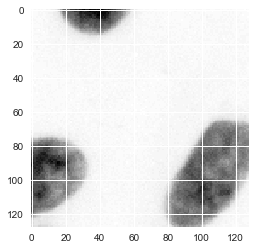

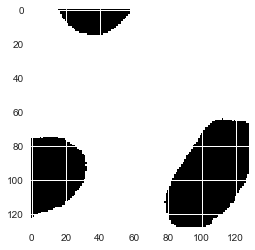

In [159]:
index = 100
plt.imshow(sub_images[index])
plt.show()
plt.imshow(sub_masks[index])
plt.show()


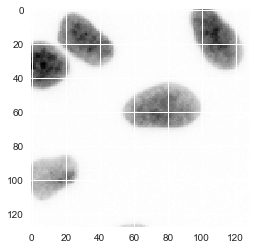

In [102]:
plt.imshow(sub_images[101])

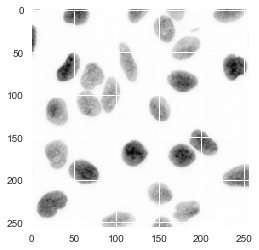

In [99]:
plt.imshow(sub_images[101])

# Step 5: Get Training Data and split

In [160]:
X = sub_images.reshape(sub_images.shape[0], IMG_WIDTH, IMG_HEIGHT, 1)
y = sub_masks.reshape(sub_masks.shape[0], IMG_WIDTH, IMG_HEIGHT, 1)

# make sure our data is clean
# assert np.sum(np.isnan(X)) == 0
# assert np.sum(np.isnan(y)) == 0

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [136]:
sub_images.shape

(50, 128, 128)

# Overfit Experiment

In [179]:
jacks_unet = UNET(X_train)

In [ ]:
jacks_unet.train(X_train, y_train, X_test, y_test)

done setting up
Train on 144 samples, validate on 16 samples
Epoch 1/10
144/144 [==============================] - 14s - loss: 0.6926 - mean_iou: 0.3884 - val_loss: 0.6893 - val_mean_iou: 0.4152
Epoch 2/10
144/144 [==============================] - 9s - loss: 0.6877 - mean_iou: 0.4195 - val_loss: 0.6845 - val_mean_iou: 0.4208
Epoch 3/10
120/144 [========================>.....] - ETA: 1s - loss: 0.6831 - mean_iou: 0.4231

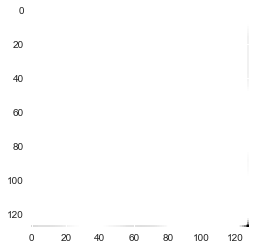

In [175]:
i=3
plt.imshow(jacks_unet.predict(X_train[i:i+1])[0].reshape((128,128)))
plt.show()
plt.imshow()

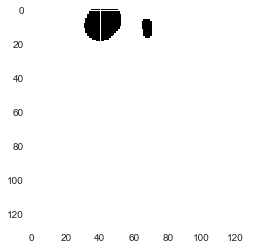

In [18]:
plt.imshow(y_train[4].reshape(128,128))

# Step 6: Train!!!

In [ ]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [1]:
X_train.shape

NameError: name 'X_train' is not defined

In [420]:
unet = UNET(X_train)
#unet.train(X_train, y_train)
unet.load_weights("best_unet_weights_4_8_18")

## Train/Val Loss

In [ ]:
plt.plot(unet.history.history['loss'])
plt.plot(unet.history.history['val_loss'])
plt.title('UNet Binary cross-entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], loc='upper right')


# UNET Pipeline!!! Let's gooooo!

In [300]:
# convoles around an image and makes unet predictions
def unet_prediction(image):
    UNET_WIDTH = 128
    UNET_HEIGHT = 128
    # pad with 0s on right and bottom if needed
    W = image.shape[0]
    H = image.shape[1]
    WW = W + UNET_WIDTH-W%UNET_WIDTH
    HH = H + UNET_HEIGHT-H%UNET_HEIGHT
    
    padded_image = np.zeros((WW,HH))
    padded_image[0:W,0:H] = image
    padded_prediction = np.zeros((WW,HH))
    
    ii = 0
    for i in range(0, WW, UNET_WIDTH):
        jj = 0

        for j in range(0, HH, UNET_HEIGHT):
            sub_image =  padded_image[ii*UNET_WIDTH:(ii+1)*UNET_WIDTH, jj*UNET_HEIGHT:(jj+1)*UNET_HEIGHT]
#             plt.imshow(sub_image)
#             plt.show()
            sub_image_re = sub_image.reshape(1, IMG_WIDTH, IMG_HEIGHT, 1)
            sub_prediction = unet.predict(sub_image_re)[0].reshape(128,128)
            
            padded_prediction[ii*UNET_WIDTH:(ii+1)*UNET_WIDTH, jj*UNET_HEIGHT:(jj+1)*UNET_HEIGHT] = sub_prediction
            jj +=1
        ii += 1
    
    return padded_prediction[0:W,0:H]


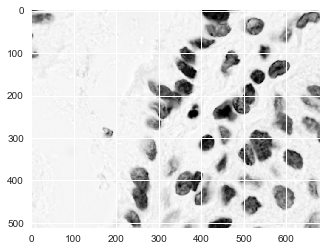

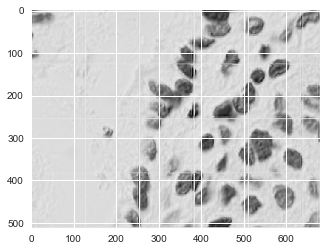

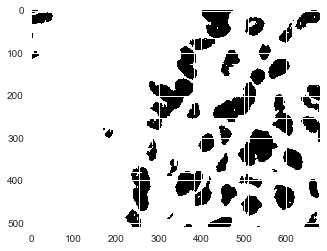

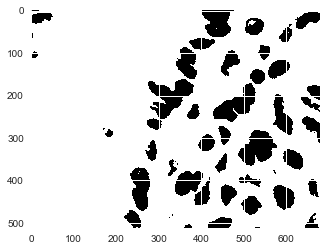

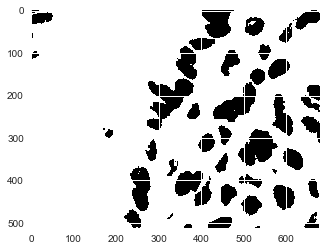

In [145]:
index = 1

prediction = unet_prediction(test_image_data[index].im)

    
plt.imshow(test_image_data[index].im)
plt.show()
plt.imshow(prediction)
plt.show()
#plt.imshow(models.otsu_threshold(prediction))
unet_otsu = models.otsu_threshold(unet_prediction(test_image_data[index].im))

if np.mean(unet_otsu.flatten()) > 0.5:
    unet_otsu = 1 - unet_otsu

unet_otsu = np.where(unet_otsu==1,True,False)    
otsu_only = models.otsu_threshold(test_image_data[index].im)

felz = models.felz_seg_binary(otsu_only)

plt.imshow(unet_otsu)
plt.show()
plt.imshow(otsu_only)
plt.show()
# plt.imshow(felz)
# plt.show()
plt.imshow(np.logical_or(unet_otsu,otsu_only))
plt.show()

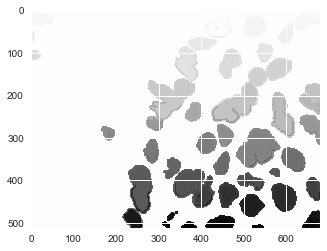

In [34]:
plt.imshow(models.felz_seg(np.logical_or(unet_otsu,otsu_only)))

In [363]:
IDs = []
predictions = []
for index in range(len(test_image_data)):
    im = test_image_data[index]
    im_id = im.path
    unet_predicted = unet_prediction(im.im)
#     if np.mean(unet_predicted.flatten()) > 0.5:
#         unet_predicted = 1 - unet_predicted
    #otsu_unet = models.otsu_threshold(unet_predicted)
    watershed_otsu_unet = models.ostu_then_watershed(unet_predicted)
    du.clean_masks(watershed_otsu_unet)
    predicted = watershed_otsu_unet
    IDs.append(im_id)
    predictions.append(predicted)
    
    

In [366]:
du.make_submission(IDs, predictions, "4_8_2018_3.csv")

2729
2729


In [365]:
len(np.unique(IDs))

65

In [172]:
# removes masks that are really small (1 or 2 pixels)
# they are probably just noise
def clean_masks(mask):
    mask_ids = np.unique(mask)
    for mask_id in mask_ids:
        if len(mask[mask == mask_id]) <= 2:
            mask[mask == mask_id] = 0
    

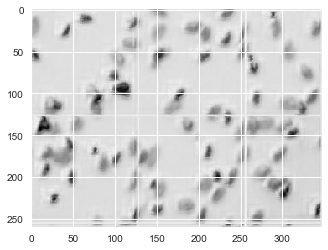

In [382]:
plt.imshow(unet_predicted)

(array([   201.,  10150.,  58653.,   9383.,   6457.,   2952.,   1266.,
           722.,    309.,    127.]),
 array([ 0.49628088,  0.49896649,  0.5016521 ,  0.50433771,  0.50702332,
         0.50970893,  0.51239454,  0.51508015,  0.51776575,  0.52045136,
         0.52313697]),
 <a list of 10 Patch objects>)

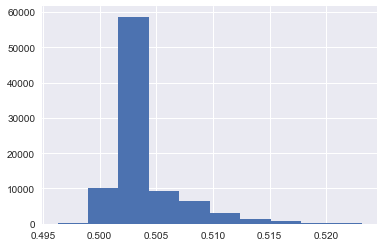

In [369]:
plt.hist(unet_predicted.flatten())

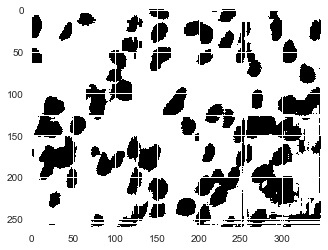

In [380]:
plt.imshow(np.where(unet_predicted>np.mean(unet_predicted),1,0))

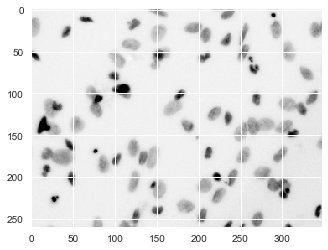

In [381]:
plt.imshow(im.im)

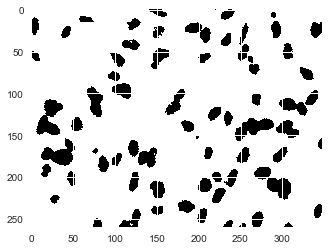

In [384]:
plt.imshow(models.otsu_threshold(im.im))

In [144]:
IDs = []
predictions = []
test_image_predictions = unet.predict(test_image_data[0])
plt.imshow(X_test[i:i+1][0].reshape(128,128))
plt.show()
predicted = unet.predict(X_test[i:i+1])[0].reshape(128,128)
plt.imshow(predicted)
# for im in test_image_data:
#     im_id = im.path
#     unet_binary_mask = unet.predict()
#     predicted = models.ostu_then_watershed(im.im)
#     IDs.append(im_id)
#     predictions.append(predicted)

TypeError: Error when checking model : data should be a Numpy array, or list/dict of Numpy arrays. Found: <data_utils.FullImage instance at 0x2afcb7b00>...

In [ ]:
du.make_submission(IDs, predictions, "4_7_2018_unet1.csv")

In [294]:
unet_prediction(train_image_data[0].im)

array([[ 0.50094539,  0.50107539,  0.50064039, ...,  0.50194186,
         0.50108349,  0.49947757],
       [ 0.50067115,  0.50129795,  0.50095087, ...,  0.50244874,
         0.50187379,  0.49936637],
       [ 0.50094211,  0.50142968,  0.50104922, ...,  0.50307697,
         0.50190592,  0.49932969],
       ..., 
       [ 0.50013494,  0.50030202,  0.50025535, ...,  0.50023258,
         0.50011945,  0.49992865],
       [ 0.50010854,  0.50012696,  0.50014693, ...,  0.50011164,
         0.49995506,  0.49990878],
       [ 0.50002682,  0.50007141,  0.50007361, ...,  0.49977574,
         0.49984366,  0.50000644]])

In [400]:
IDs = []
predictions = []
for im in train_image_data[0:1]:
    im_id = im.path
    unet_predicted = unet_prediction(train_image_data[0].im)
#     if np.mean(unet_predicted.flatten()) > 0.5:
#         unet_predicted = 1 - unet_predicted
    #otsu_unet = models.otsu_threshold(unet_predicted)
    watershed_otsu_unet = models.ostu_then_watershed(unet_predicted)
    otsu_only = models.otsu_threshold(train_image_data[0].im)
    du.clean_masks(watershed_otsu_unet)
    predicted = watershed_otsu_unet
    IDs.append(im_id)
    predictions.append(predicted)
du.make_submission(IDs, predictions, "train_test.csv")

12
12


(array([ 61923.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,   3613.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

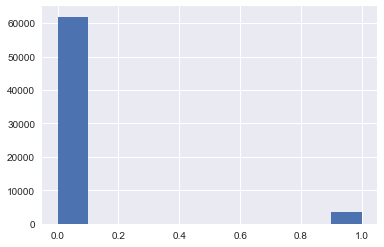

In [142]:
plt.hist(predicted.flatten())

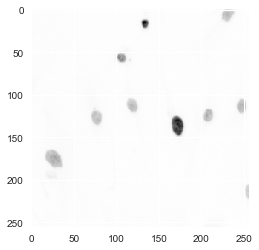

In [458]:
plt.imshow(test_image_data[0].im)

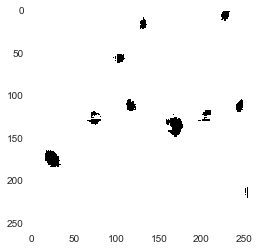

In [460]:
u_pred = unet_prediction(test_image_data[0].im)
plt.imshow(models.otsu_threshold(u_pred))

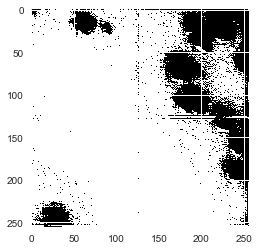

In [403]:
plt.imshow(np.where(unet_predicted>np.mean(unet_predicted),1,0))

In [409]:

clean = np.where(unet_predicted>np.mean(unet_predicted),1,0)
du.clean_masks(clean)
                 

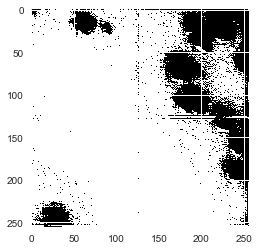

In [410]:
plt.imshow(clean)

In [393]:
scipy.stats.describe(unet_predicted.flatten())

DescribeResult(nobs=65536, minmax=(0.49514669179916382, 0.52114474773406982), mean=0.50240599566586752, variance=3.667090896528577e-06, skewness=1.6276812652489874, kurtosis=4.996868175455415)

(array([  1.10000000e+01,   1.68500000e+03,   2.00260000e+04,
          1.21910000e+04,   4.28300000e+03,   2.88000000e+02,
          1.24000000e+02,   5.30000000e+01,   2.80000000e+01,
          1.30000000e+01]),
 array([ 0.49514669,  0.4977465 ,  0.5003463 ,  0.50294611,  0.50554591,
         0.50814572,  0.51074553,  0.51334533,  0.51594514,  0.51854494,
         0.52114475]),
 <a list of 10 Patch objects>)

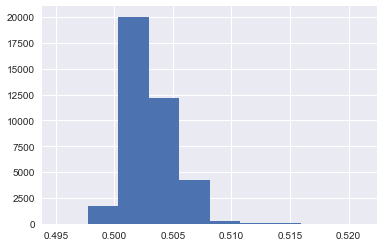

In [392]:
plt.hist(np.unique(unet_predicted.flatten()))

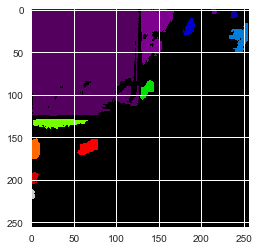

In [352]:
plt.imshow(watershed_otsu_unet,cmap="spectral")

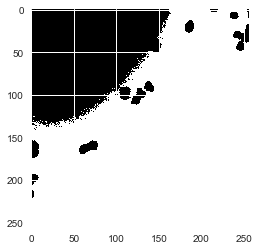

In [353]:
plt.imshow(otsu_only)

(array([ 62509.,      0.,    441.,      0.,      0.,    201.,   1129.,
           350.,    325.,    581.]),
 array([  0. ,   1.8,   3.6,   5.4,   7.2,   9. ,  10.8,  12.6,  14.4,
         16.2,  18. ]),
 <a list of 10 Patch objects>)

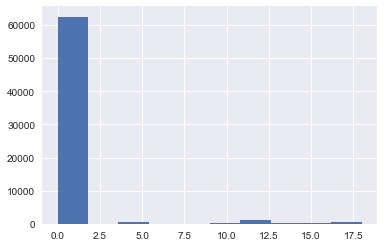

In [331]:
plt.hist(watershed_otsu_unet.flatten())

0


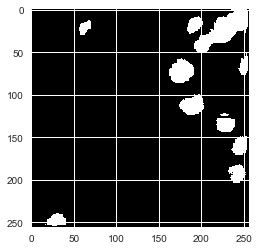

1


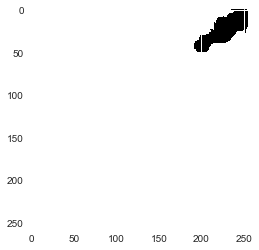

2


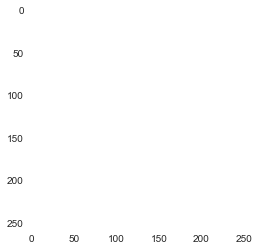

3


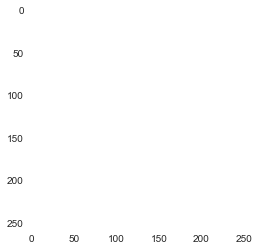

4


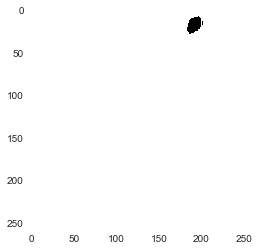

5


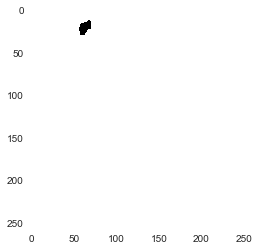

6


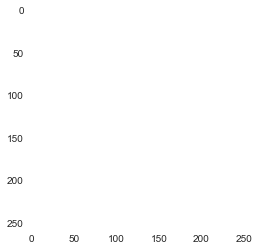

7


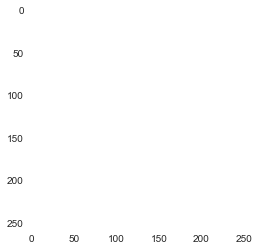

8


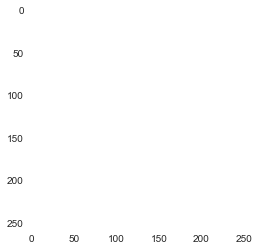

9


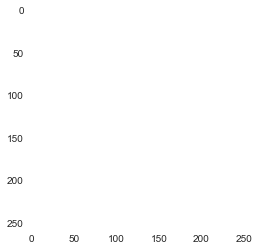

10


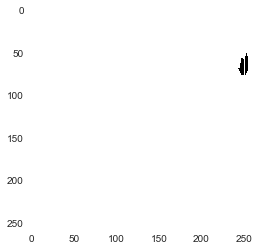

11


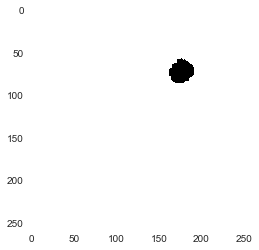

12


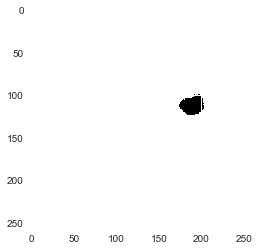

13


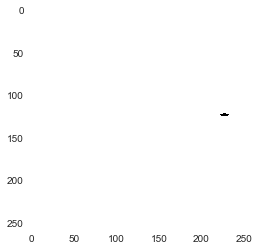

14


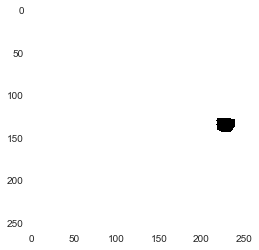

15


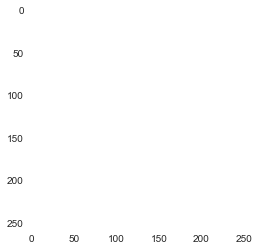

16


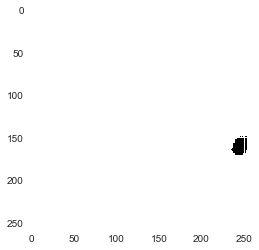

17


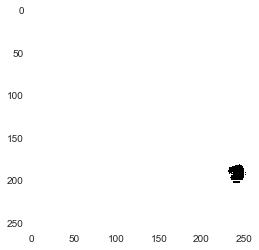

18


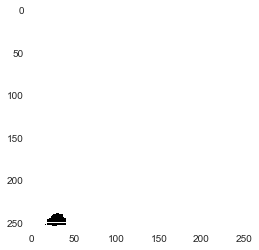

19


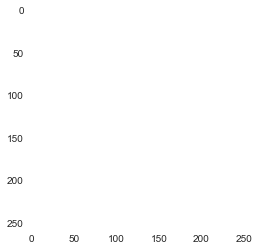

In [333]:
for i in range(20):
    print i
    plt.imshow(np.where(predicted==i,1,0))
    plt.show()

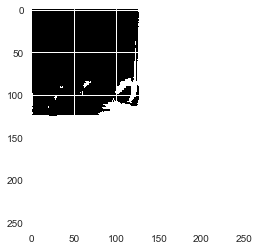

In [346]:
rle = "257 99 371 1 374 4 380 2 513 125 769 125 1025 125 1281 125 1537 125 1793 125 2049 125 2305 125 2561 125 2817 125 3073 125 3329 125 3585 125 3841 125 4097 125 4353 125 4609 125 4865 125 5121 114 5237 9 5377 126 5633 126 5889 126 6145 126 6401 126 6657 126 6913 103 7018 21 7169 101 7276 19 7425 101 7530 21 7681 101 7786 21 7937 101 8039 23 8193 125 8449 125 8705 91 8798 32 8961 92 9054 32 9217 90 9310 32 9473 125 9729 125 9985 125 10241 125 10497 125 10753 125 11009 125 11265 125 11521 125 11777 125 12033 125 12289 125 12545 125 12801 125 13057 125 13313 125 13569 125 13825 125 14081 125 14337 125 14593 125 14849 98 14948 26 15105 125 15361 96 15462 24 15617 89 15708 34 15873 87 15966 32 16129 87 16221 33 16385 85 16471 1 16477 33 16641 85 16732 34 16897 85 16986 1 16988 34 17153 85 17242 36 17409 86 17496 38 17665 85 17752 38 17921 125 18177 125 18433 125 18689 125 18945 125 19201 125 19457 125 19713 125 19969 125 20225 122 20348 2 20481 122 20605 1 20737 121 20861 1 20993 121 21117 1 21249 115 21365 4 21505 121 21761 112 21874 2 21878 4 22017 112 22130 2 22134 3 22273 112 22387 1 22390 3 22529 112 22647 2 22785 111 22903 2 23041 108 23150 2 23159 2 23297 109 23415 2 23553 109 23671 2 23809 109 24065 109 24321 107 24577 105 24684 2 24833 108 25089 107 25345 96 25444 9 25601 93 25695 1 25700 9 25857 91 25957 8 26113 91 26213 9 26369 89 26468 10 26625 87 26725 10 26881 86 26979 12 27137 85 27234 14 27393 85 27488 15 27649 85 27744 15 27905 85 27998 17 28161 82 28254 18 28417 82 28509 19 28673 82 28764 20 28929 82 29020 17 29038 2 29185 81 29275 18 29294 2 29441 81 29532 14 29550 2 29697 81 29788 10 29807 1 29809 1 29953 77 30033 2 30046 1 30048 4 30061 1 30063 3 30209 85 30317 1 30319 4 30465 86 30572 7 30721 80 30802 2 30827 8 30977 61 31080 11 31233 37 31275 4 31336 11 31489 85 31586 17 31745 114 32001 59 32061 1 32090 1 32092 19 32113 1 32258 1 32261 7 32269 2 32272 2 32277 1 32348 16"
plt.imshow(du.rle_decode(rle,(256, 256),int))

In [112]:
labels,num = skimage.measure.label(predicted, return_num=True)
print "num nuclei:",len(np.unique(labels))

num nuclei: 18


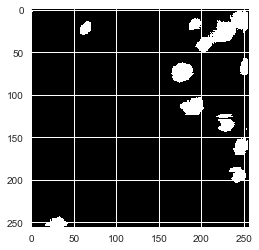

In [113]:
plt.imshow(np.where(labels==0,1,0))

0


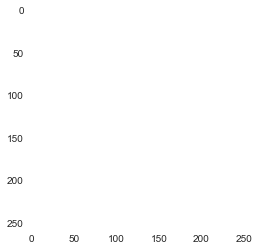

In [133]:
lab = 
print len(labels[labels==lab])
plt.imshow(np.where(labels==lab,1,0))

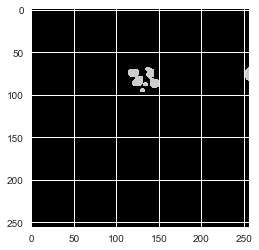

In [483]:
plt.imshow(total_masks[3],cmap="spectral")

In [491]:
cseg = comseg.community_segmentation(total_masks[2])

[autoreload of community_segmentation failed: Traceback (most recent call last):
  File "/anaconda/lib/python2.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ImportError: No module named tqdm
]


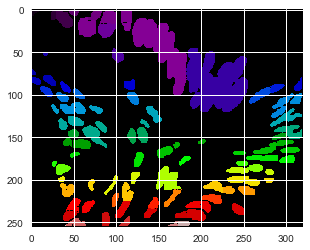

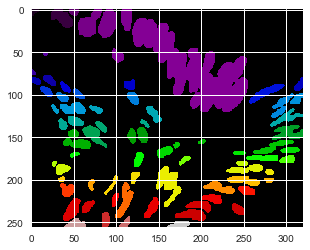

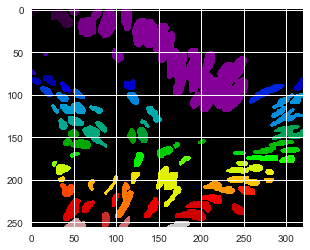

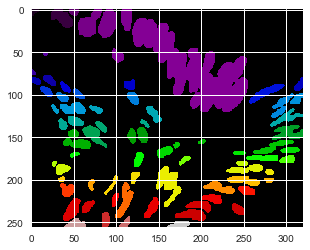

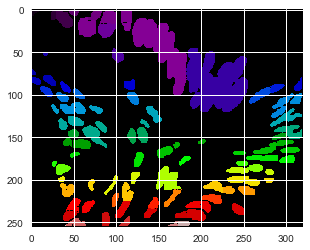

In [493]:
index = 2
plt.imshow(scipy.ndimage.label(total_masks[index])[0],cmap="spectral")
plt.show()
labels,num = skimage.measure.label(total_masks[index], return_num=True)
plt.imshow(labels,cmap="spectral")
plt.show()
plt.imshow(models.watershed_seg(total_masks[index]),cmap="spectral")
plt.show()
plt.imshow(cseg,cmap="spectral")

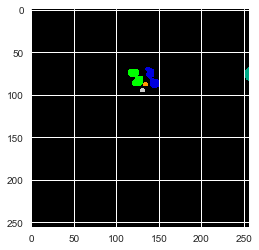

In [505]:
plt.imshow(models.watershed_seg(total_masks[3]),cmap = "nipy_spectral")

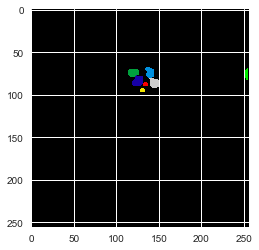

In [504]:
plt.imshow(cseg2,cmap="nipy_spectral")

In [498]:
cseg2 = comseg.community_segmentation(total_masks[3])

# K-Means experiment

In [ ]:
skimage